## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#display configurations
%config InlineBackend.figure_format = 'retina'
import os
from sklearn import set_config
set_config(display='diagram', transform_output='pandas')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.preprocessing import LabelEncoder

In [3]:
# for  tracking our modelling experiments
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
# Creating a writer with all default settings
writer = SummaryWriter()

2025-02-19 21:58:35.506993: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Loading data file

In [7]:
new_df=pd.read_csv("/bsuhome/maishamaliha/scratch/First_chapter_ML/ml_dataset_14site.csv")
new_df.info(memory_usage='deep')
#new_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10130 entries, 0 to 10129
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Species                  10130 non-null  object 
 1   site                     10130 non-null  object 
 2   area                     10130 non-null  float64
 3   perimeter                10130 non-null  float64
 4   edge_to_area_ratio       10130 non-null  float64
 5   rgb_stdev.red            10130 non-null  float64
 6   rgb_stdev.green          10130 non-null  float64
 7   rgb_stdev.blue           10130 non-null  float64
 8   rgb_mean.red             10130 non-null  float64
 9   rgb_mean.green           10130 non-null  float64
 10  rgb_mean.blue            10130 non-null  float64
 11  multispec_stdev.Red      10118 non-null  float64
 12  multispec_stdev.RedEdge  10119 non-null  float64
 13  multispec_stdev.NIR      10120 non-null  float64
 14  multispec_mean.Red    

In [8]:
new_df.isnull().sum()

Species                     0
site                        0
area                        0
perimeter                   0
edge_to_area_ratio          0
rgb_stdev.red               0
rgb_stdev.green             0
rgb_stdev.blue              0
rgb_mean.red                0
rgb_mean.green              0
rgb_mean.blue               0
multispec_stdev.Red        12
multispec_stdev.RedEdge    11
multispec_stdev.NIR        10
multispec_mean.Red         12
multispec_mean.RedEdge     11
multispec_mean.NIR         10
spec_mean.ndvi             18
spec_mean.msavi            18
spec_stdev.msavi           18
spec_stdev.ndvi            18
chm_mean                    0
chm_stdev                   0
chm_min                     0
chm_max                     0
elev                        0
slope                       0
dtype: int64

In [9]:
#removing null values

ml_df= new_df.dropna()
ml_df.isnull().sum()
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10112 entries, 0 to 10129
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Species                  10112 non-null  object 
 1   site                     10112 non-null  object 
 2   area                     10112 non-null  float64
 3   perimeter                10112 non-null  float64
 4   edge_to_area_ratio       10112 non-null  float64
 5   rgb_stdev.red            10112 non-null  float64
 6   rgb_stdev.green          10112 non-null  float64
 7   rgb_stdev.blue           10112 non-null  float64
 8   rgb_mean.red             10112 non-null  float64
 9   rgb_mean.green           10112 non-null  float64
 10  rgb_mean.blue            10112 non-null  float64
 11  multispec_stdev.Red      10112 non-null  float64
 12  multispec_stdev.RedEdge  10112 non-null  float64
 13  multispec_stdev.NIR      10112 non-null  float64
 14  multispec_mean.Red       10

## Analyzing the plant species

In [10]:
plt.figure(figsize=(11, 6))

val_count=ml_df['Species'].value_counts()
val_count

Species
ARTR       5438
ARAR       2503
CHVI        453
ERNA        350
ARTRW       287
Dead        233
AGCR        215
PUTR        173
ACTH        128
ELEL         94
Lupinus      93
PSSP         82
Cirsium      22
ARTRV        21
CHJU         20
Name: count, dtype: int64

<Figure size 1100x600 with 0 Axes>

### Merging  ARTR, ARTRV, and ARTRW  into a single class: ARTR

In [11]:
ml_df['Species'] = ml_df['Species'].replace({'ARTRW': 'ARTR', 'ARTRV': 'ARTR'})
ml_df['Species'].unique()

/tmp/ipykernel_28979/4107427283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_df['Species'] = ml_df['Species'].replace({'ARTRW': 'ARTR', 'ARTRV': 'ARTR'})


array(['ACTH', 'AGCR', 'ARAR', 'ARTR', 'CHJU', 'CHVI', 'Cirsium', 'Dead',
       'ELEL', 'ERNA', 'Lupinus', 'PSSP', 'PUTR'], dtype=object)

In [12]:
val_count=ml_df['Species'].value_counts()
val_count

Species
ARTR       5746
ARAR       2503
CHVI        453
ERNA        350
Dead        233
AGCR        215
PUTR        173
ACTH        128
ELEL         94
Lupinus      93
PSSP         82
Cirsium      22
CHJU         20
Name: count, dtype: int64

<Axes: xlabel='Species'>

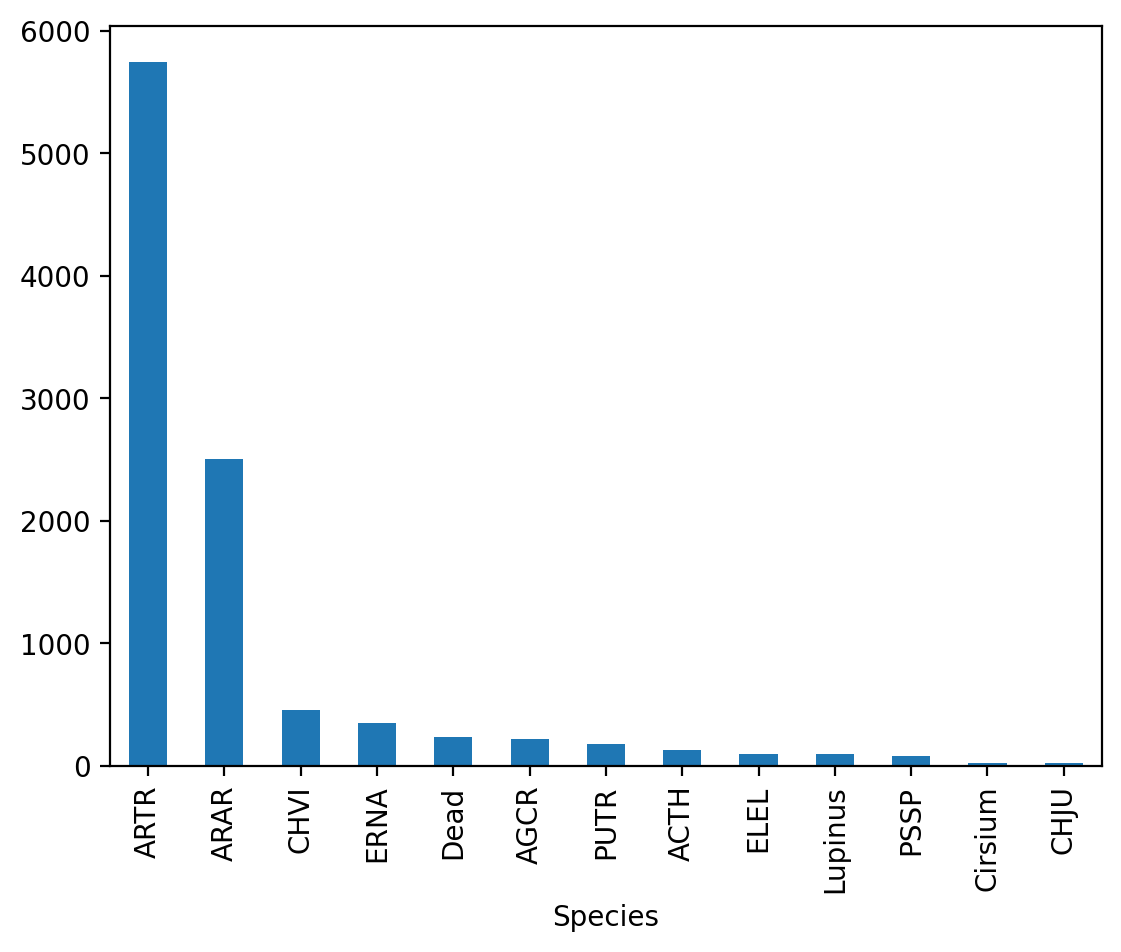

In [19]:
val_count.plot.bar()

# We will predict species using other variables as features dropping site variable.

In [21]:
ml_df.columns.tolist()

['Species',
 'site',
 'area',
 'perimeter',
 'edge_to_area_ratio',
 'rgb_stdev.red',
 'rgb_stdev.green',
 'rgb_stdev.blue',
 'rgb_mean.red',
 'rgb_mean.green',
 'rgb_mean.blue',
 'multispec_stdev.Red',
 'multispec_stdev.RedEdge',
 'multispec_stdev.NIR',
 'multispec_mean.Red',
 'multispec_mean.RedEdge',
 'multispec_mean.NIR',
 'spec_mean.ndvi',
 'spec_mean.msavi',
 'spec_stdev.msavi',
 'spec_stdev.ndvi',
 'chm_mean',
 'chm_stdev',
 'chm_min',
 'chm_max',
 'elev',
 'slope']

####  splitting data into test-train

In [13]:
features= ['area',
 'perimeter',
 'edge_to_area_ratio',
 'rgb_stdev.red',
 'rgb_stdev.green',
 'rgb_stdev.blue',
 'rgb_mean.red',
 'rgb_mean.green',
 'rgb_mean.blue',
 'multispec_stdev.Red',
 'multispec_stdev.RedEdge',
 'multispec_stdev.NIR',
 'multispec_mean.Red',
 'multispec_mean.RedEdge',
 'multispec_mean.NIR',
 'spec_mean.ndvi',
 'spec_mean.msavi',
 'spec_stdev.msavi',
 'spec_stdev.ndvi',
 'chm_mean',
 'chm_stdev',
 'chm_min',
 'chm_max',
 'elev',
 'slope']


X, y = ml_df.loc[:, features],ml_df['Species']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .25,stratify=y, random_state= 42)
print(f"Data Split: {len(X_train)} training samples, {len(X_test)} testing samples.")


Data Split: 7584 training samples, 2528 testing samples.


#Preparing data to fit ML models
#### Encoding numerical and categorical variable for pipeline

In [14]:

numeric_transformer= Pipeline(steps=[("scaler", StandardScaler()) ])

categorical_transformer= Pipeline(steps=[ ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

preprocessor1 = ColumnTransformer(transformers=[("num", numeric_transformer, features)])

    

In [15]:
y_test.value_counts(normalize=True)

Species
ARTR       0.568434
ARAR       0.247627
CHVI       0.044699
ERNA       0.034810
Dead       0.022943
AGCR       0.021361
PUTR       0.017009
ACTH       0.012658
ELEL       0.009494
Lupinus    0.009098
PSSP       0.007911
CHJU       0.001978
Cirsium    0.001978
Name: proportion, dtype: float64

#### let's write a function for  traing and evaluate traditional ML models RF,XGB,SVC,GBC with default settings 

In [32]:
import joblib
from datetime import datetime

def train_and_evaluate(X_train, X_test, y_train, y_test, preprocessor, model='random_forest'):
    """Trains a machine learning model, evaluates performance, logs results in TensorBoard,
    saves the trained model for future predictions, and stores plots.
    """

    # model dictionary
    models = {
        'random_forest': RandomForestClassifier(),
        'xgboost': XGBClassifier(),
        'svm': SVC(),
        'gradient_boosting': GradientBoostingClassifier()
    }

    # label encoding for XGBoost 
    if model == 'xgboost':
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(y_train)
        y_test = label_encoder.transform(y_test)

    # pipeline
    clf = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', models[model])
    ])

    # train model
    clf.fit(X_train, y_train)

    # predictions
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

   # accuracy and F1 score (weighted for class imbalance)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    # create results directory
    results_dir = "results"
    os.makedirs(results_dir, exist_ok=True)

    # saving model for future predictions
    model_filename = os.path.join(results_dir, f"{model}_model.joblib")
    joblib.dump(clf, model_filename)
    print(f"Model saved to {model_filename}")

    #  confusion matrix plot
    cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap='YlGnBu')
    plt.title(f"Confusion Matrix - {model}", fontsize=14)
    
    plot_filename = os.path.join(results_dir, f"{model}_confusion_matrix.png")
    plt.savefig(plot_filename, bbox_inches='tight')
    plt.show()
    print(f"Confusion matrix plot saved to {plot_filename}")

    print("Train Accuracy:", train_acc)
    print("Test Accuracy:", test_acc)
    print("Train F1 Score:", train_f1)
    print("Test F1 Score:", test_f1)

In [35]:
print( XGBClassifier().attributes())

AttributeError: 'XGBClassifier' object has no attribute 'attributes'

Model saved to results/random_forest_model.joblib


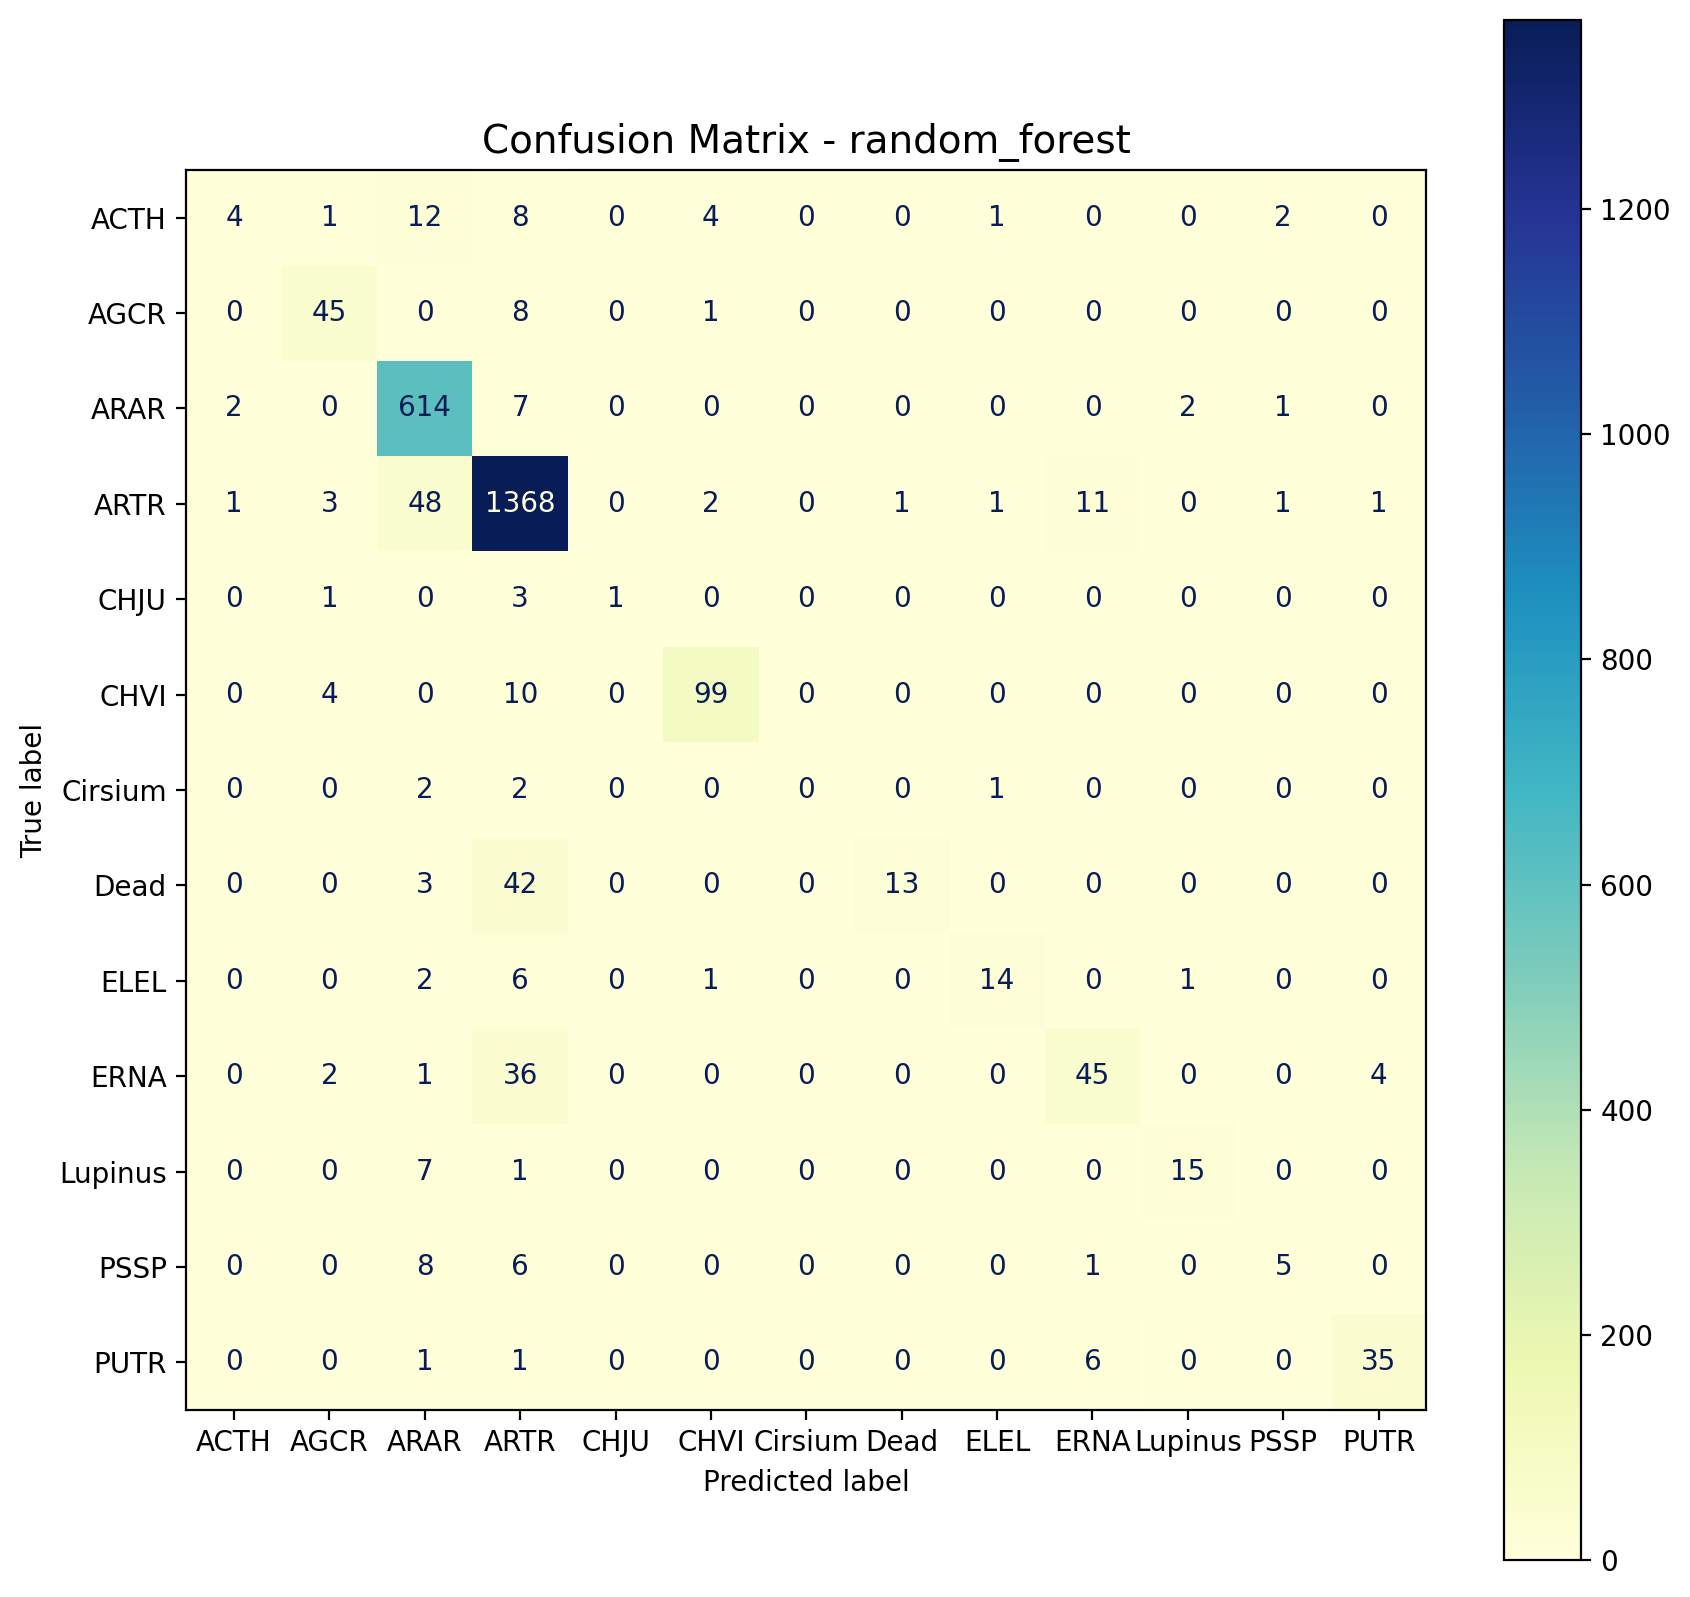

Confusion matrix plot saved to results/random_forest_confusion_matrix.png
Train Accuracy: 1.0
Test Accuracy: 0.8931962025316456
Train F1 Score: 1.0
Test F1 Score: 0.8797732325115376


In [22]:
train_and_evaluate(X_train, X_test, y_train, y_test, preprocessor= preprocessor1, model='random_forest')

Model saved to results/gradient_boosting_model.joblib


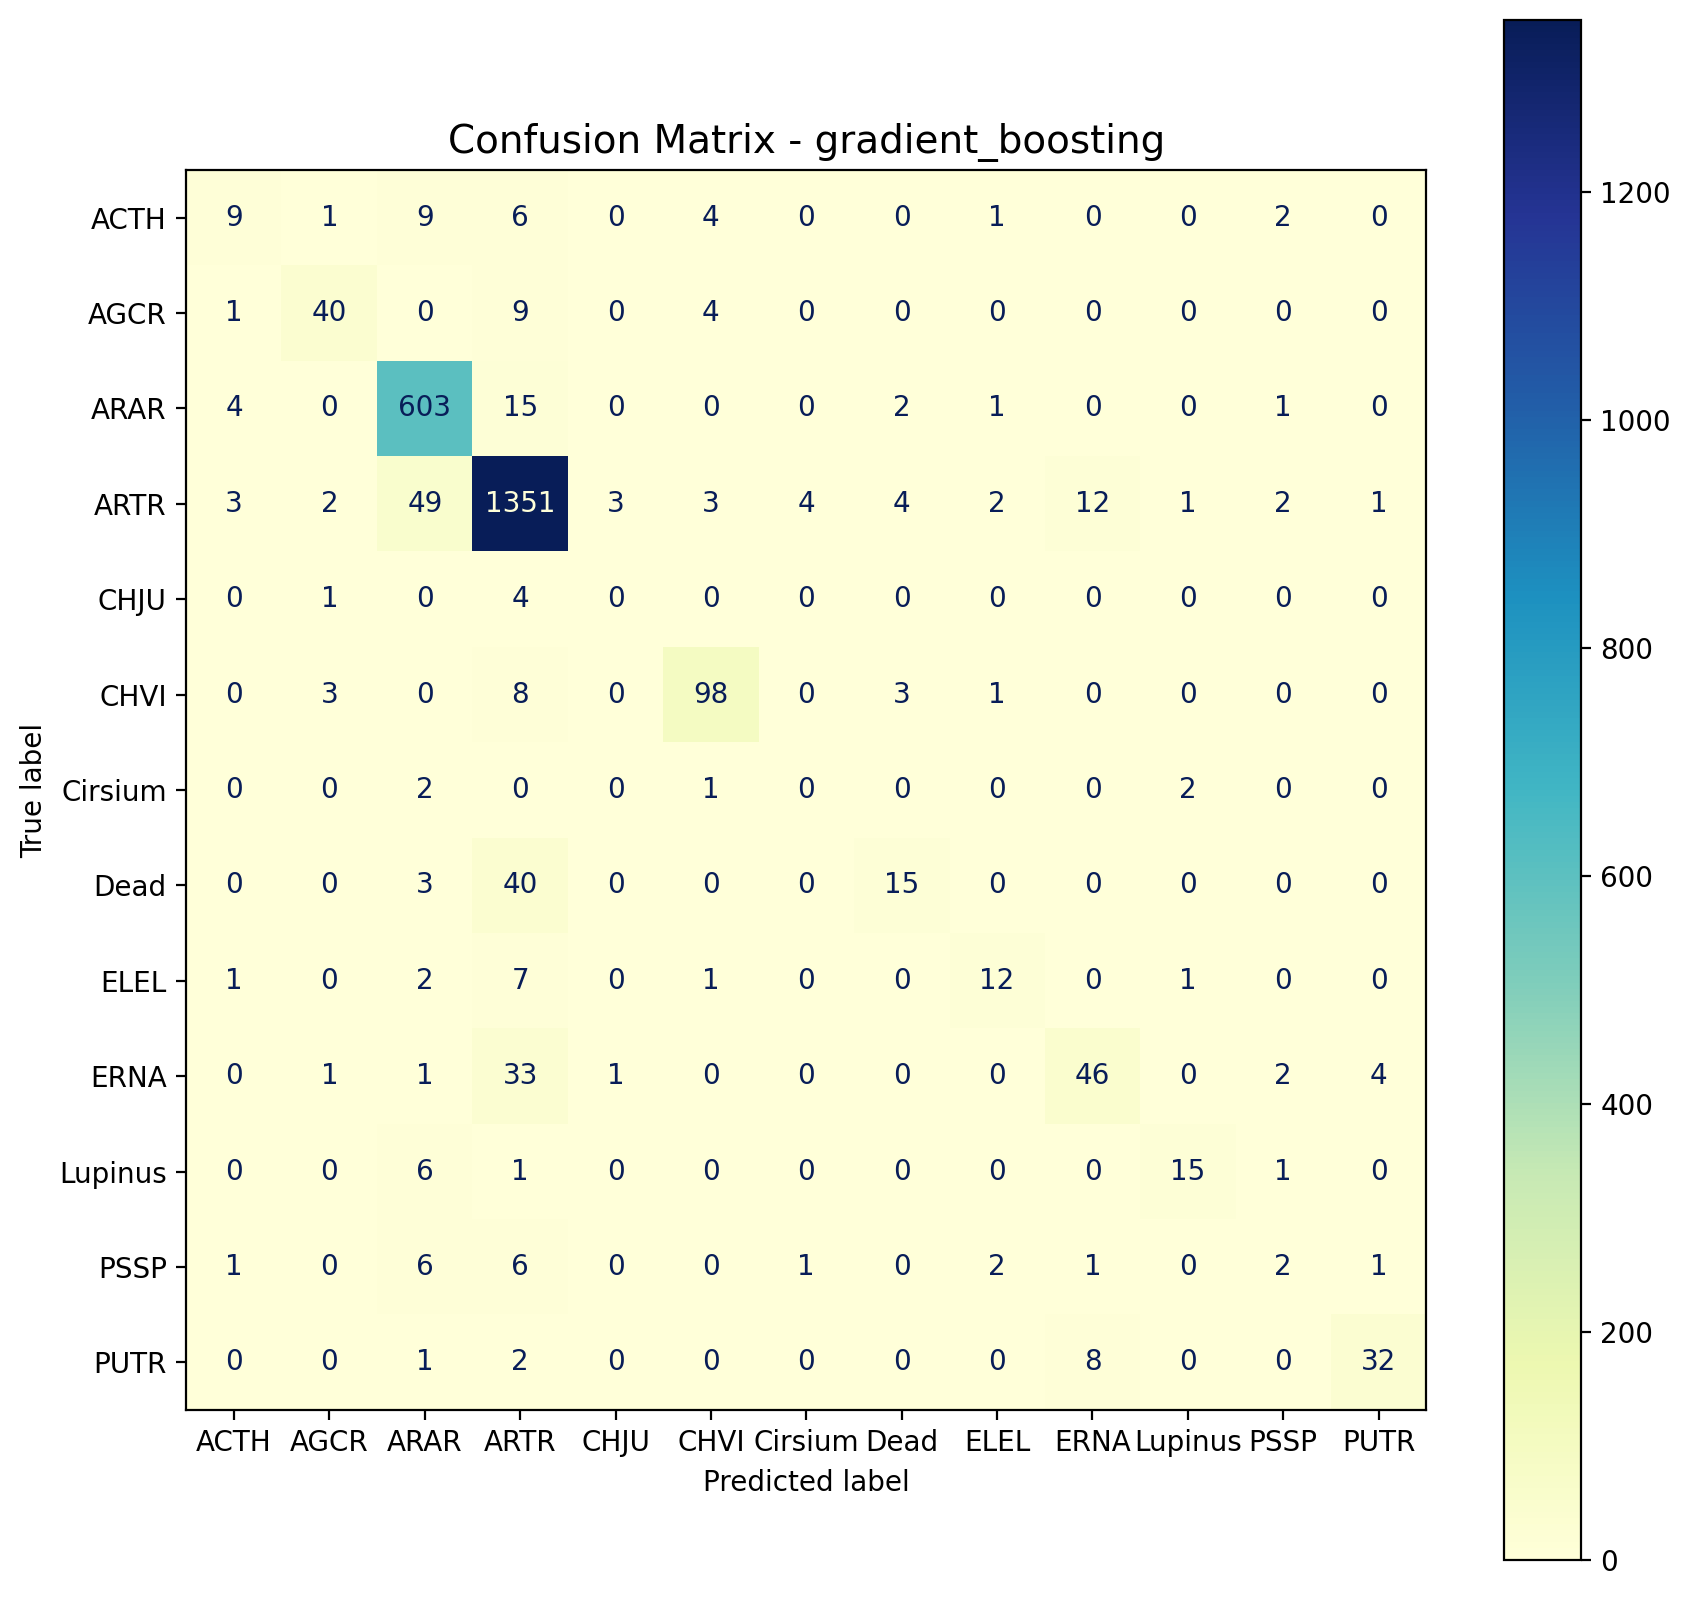

Confusion matrix plot saved to results/gradient_boosting_confusion_matrix.png
Train Accuracy: 0.9659810126582279
Test Accuracy: 0.8793512658227848
Train F1 Score: 0.965270456217144
Test F1 Score: 0.870172418024773


In [17]:
train_and_evaluate(X_train, X_test, y_train, y_test, preprocessor= preprocessor1, model='gradient_boosting')

Model saved to results/svm_model.joblib


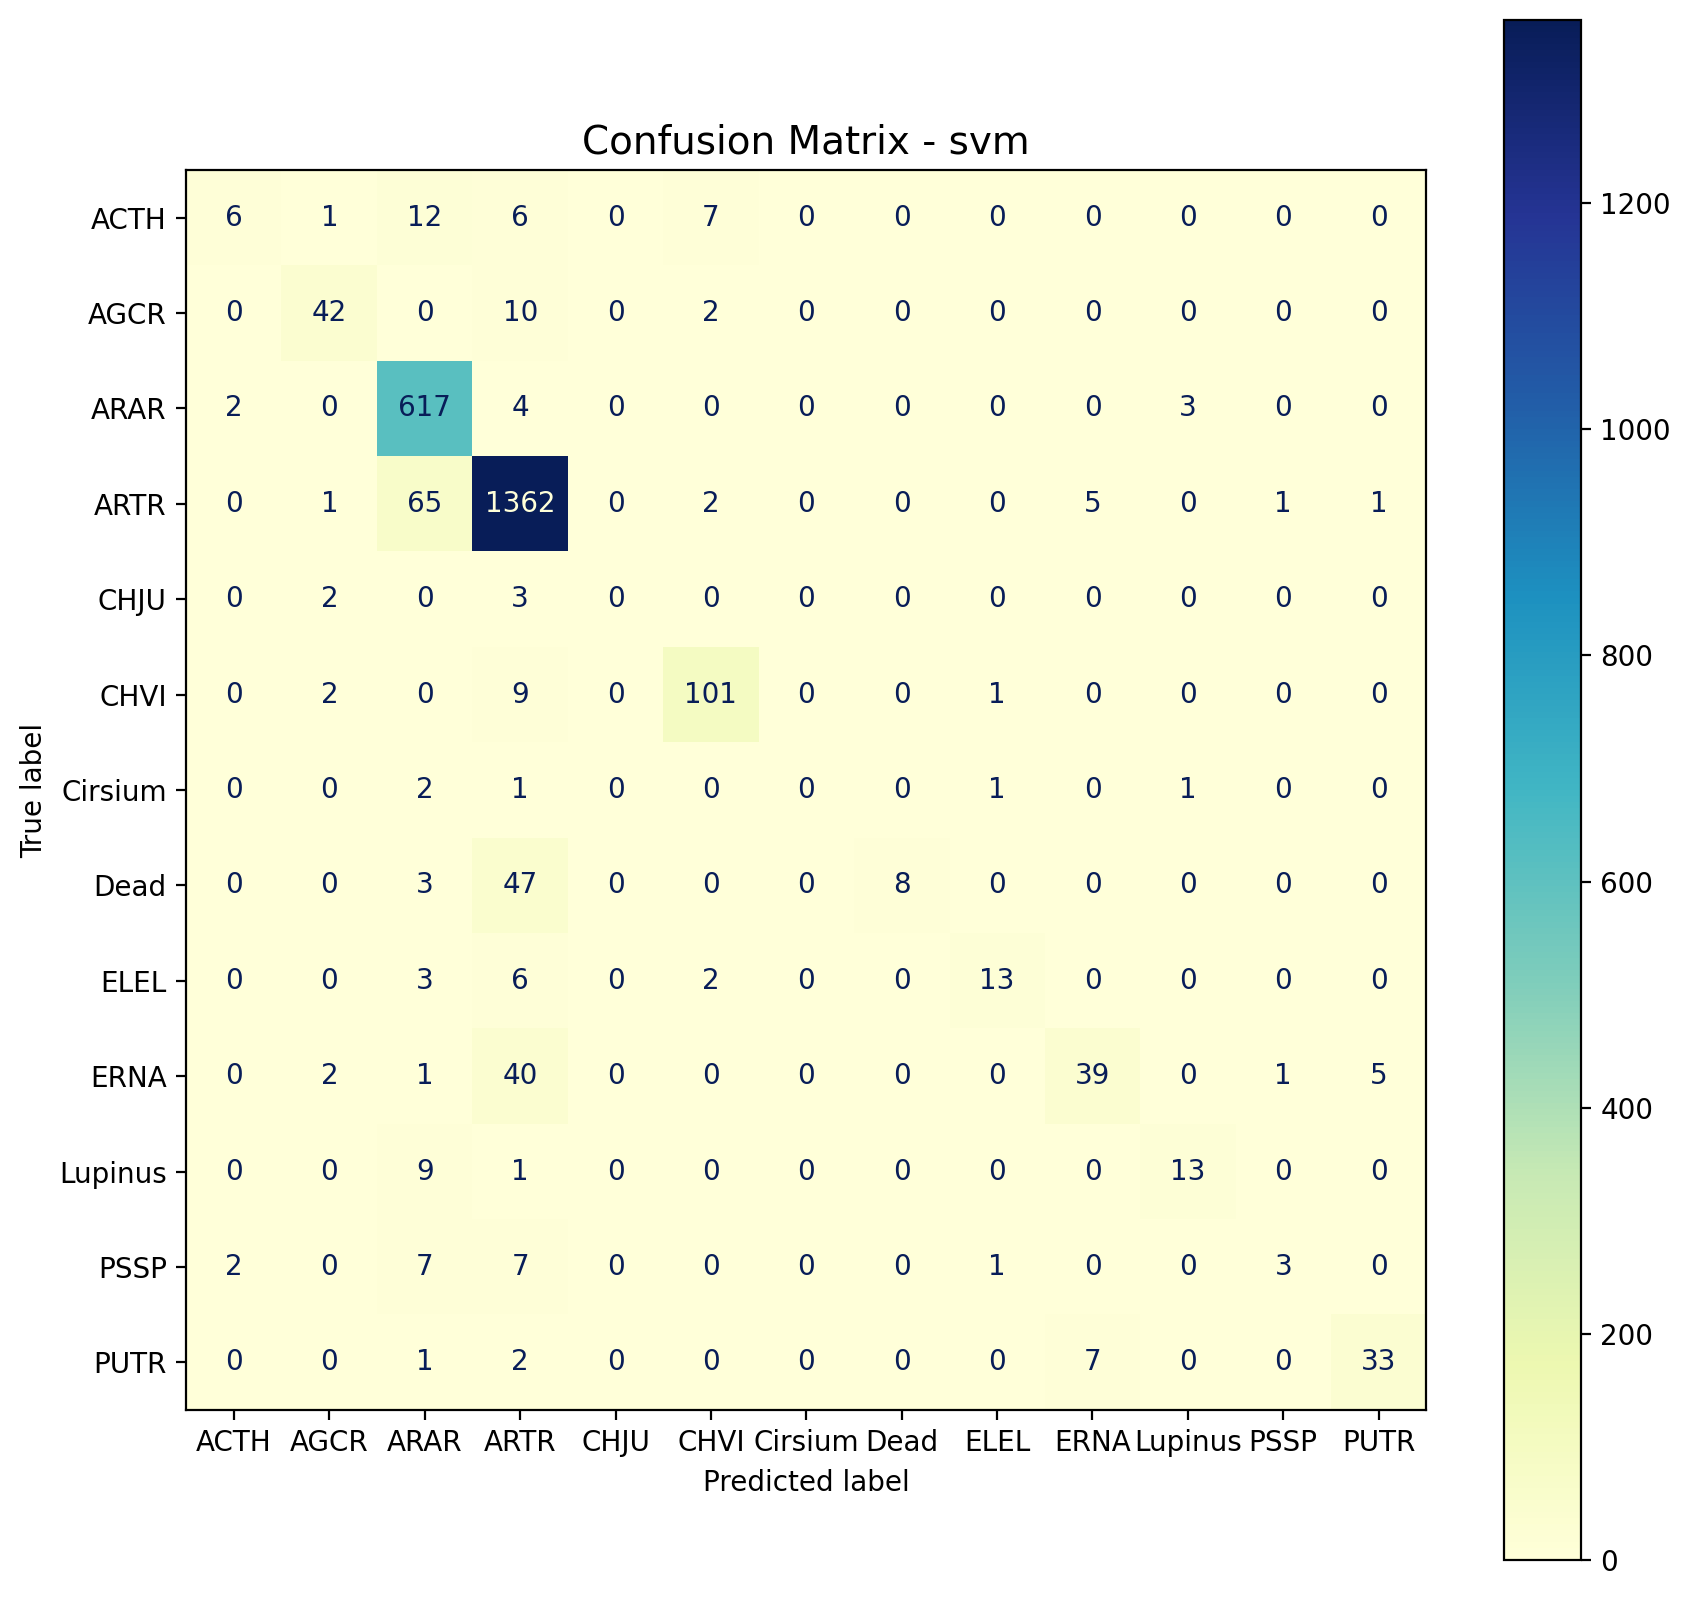

Confusion matrix plot saved to results/svm_confusion_matrix.png
Train Accuracy: 0.8947784810126582
Test Accuracy: 0.8848892405063291
Train F1 Score: 0.8802066811334901
Test F1 Score: 0.8680057304313153


In [18]:
train_and_evaluate(X_train, X_test, y_train, y_test, preprocessor= preprocessor1, model='svm')

Model saved to results/xgboost_model.joblib


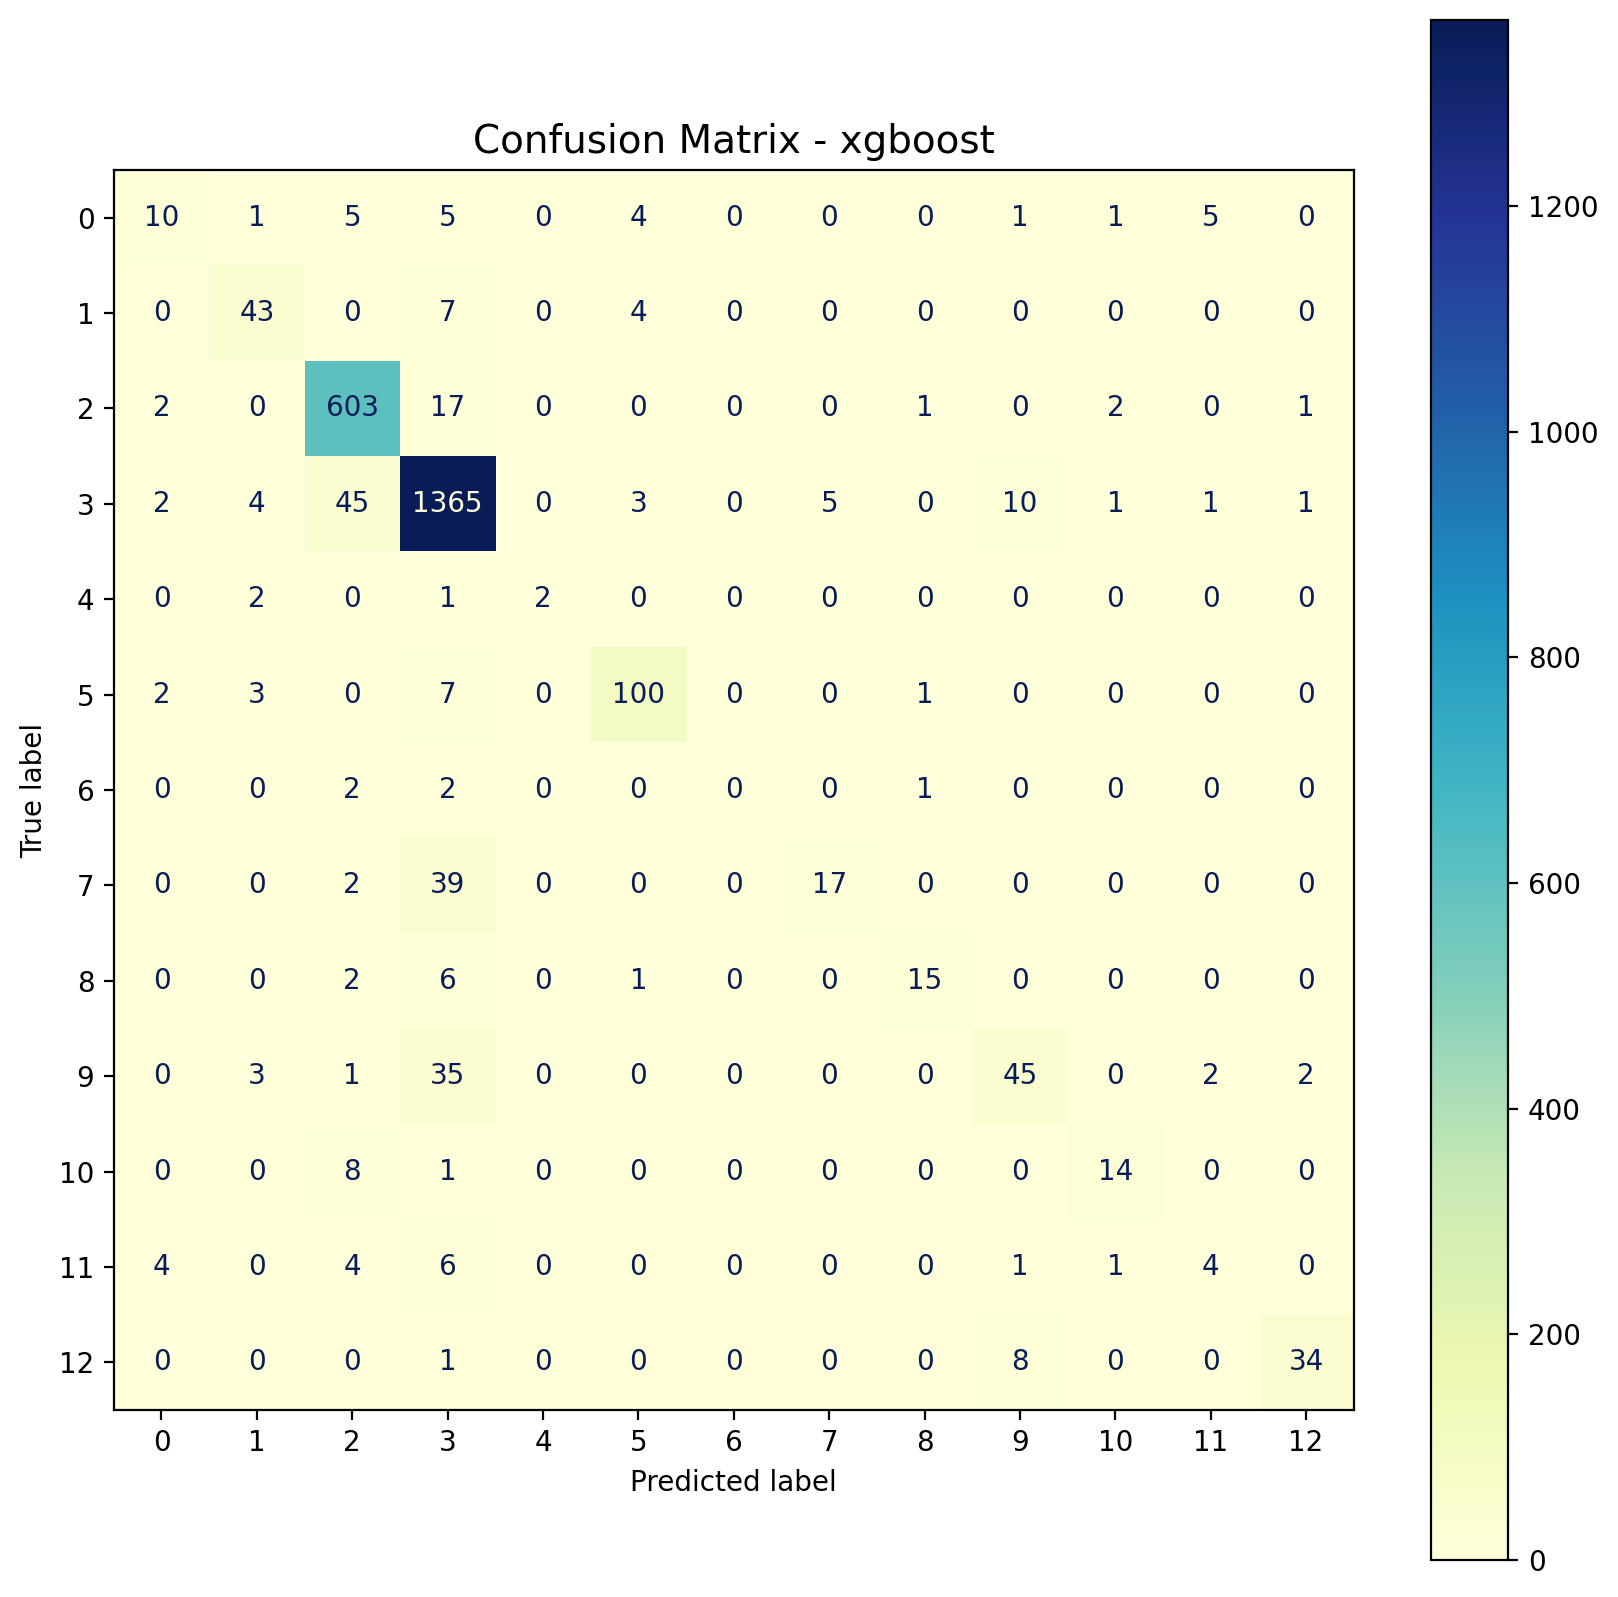

Confusion matrix plot saved to results/xgboost_confusion_matrix.png
Train Accuracy: 1.0
Test Accuracy: 0.8908227848101266
Train F1 Score: 1.0
Test F1 Score: 0.8816517834812674


In [33]:
train_and_evaluate(X_train, X_test, y_train, y_test, preprocessor= preprocessor1, model='xgboost')

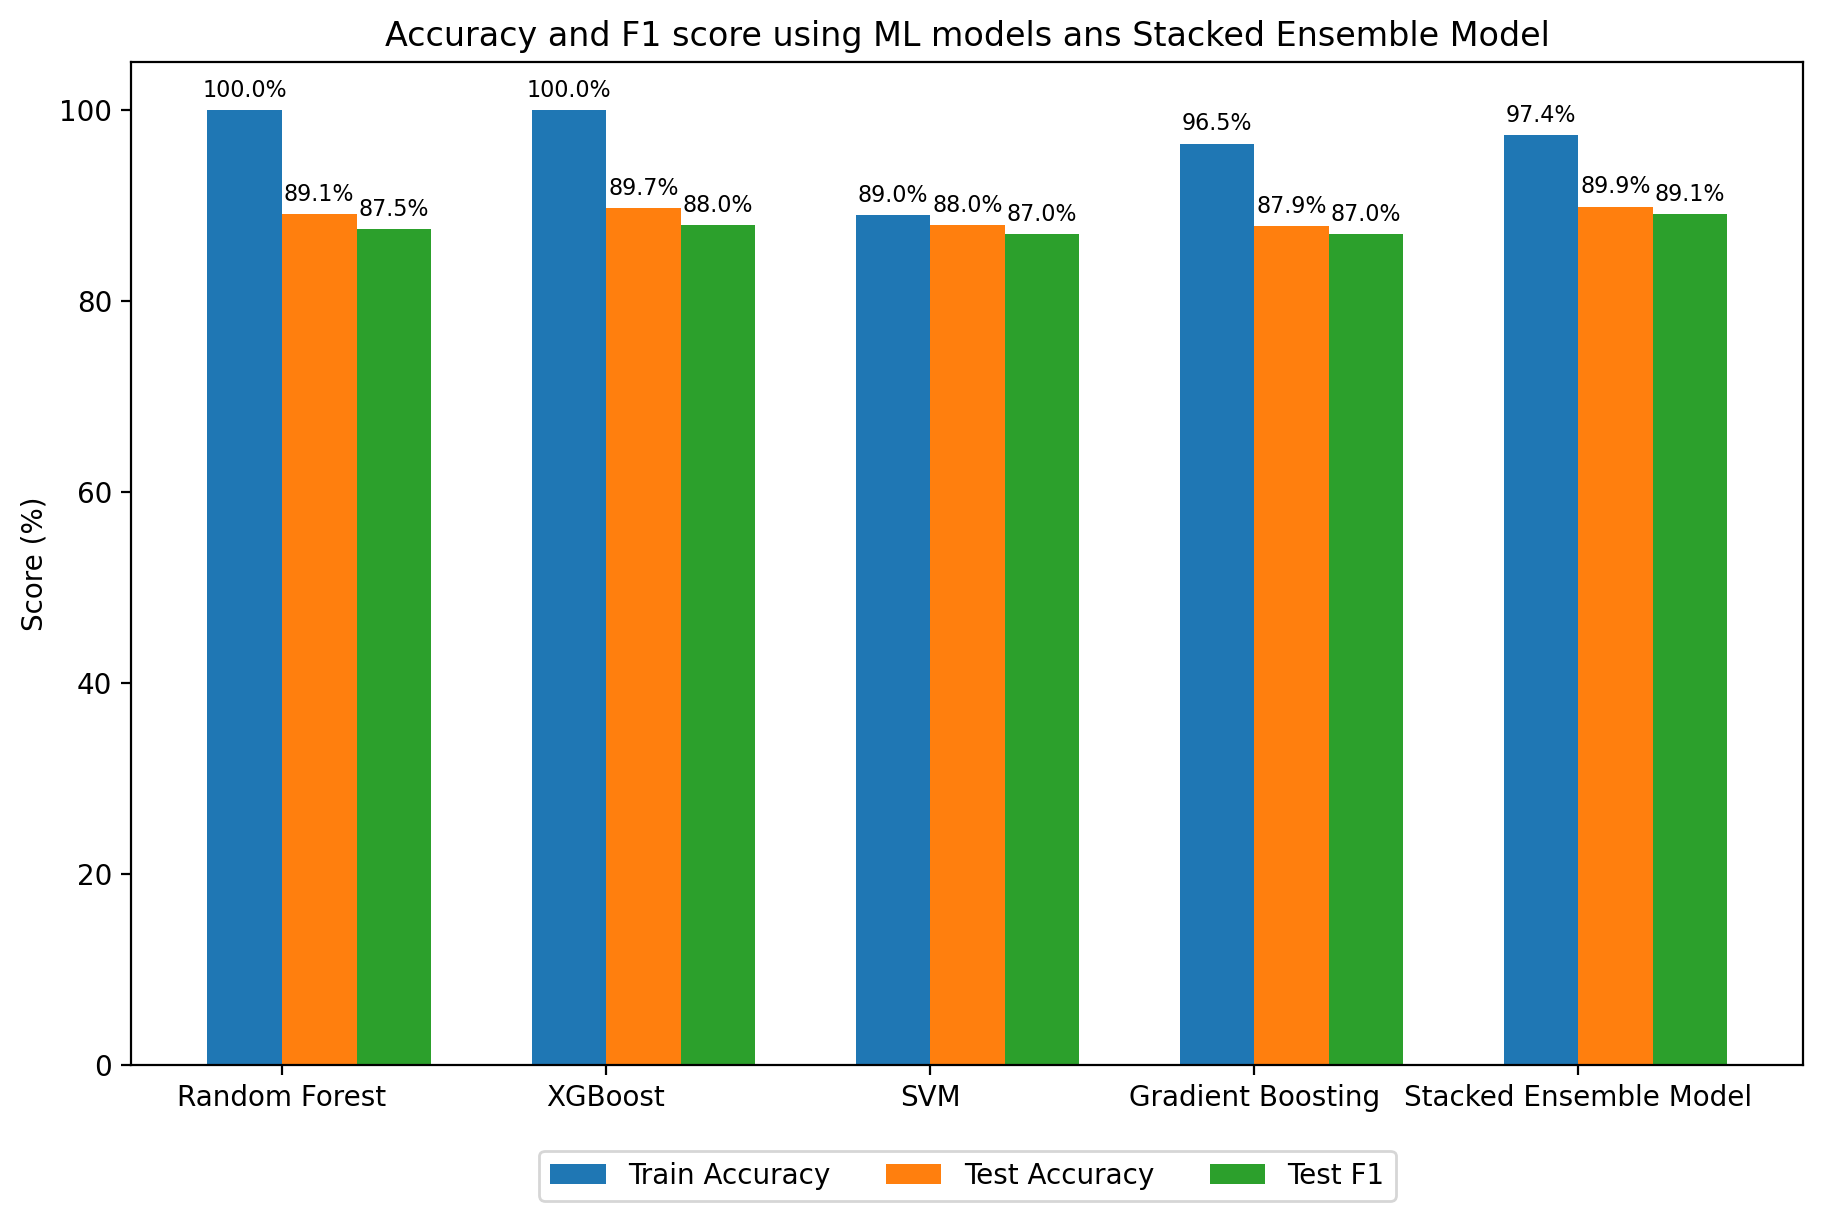

In [5]:
  # Light violet, light blue, light black (gray)


Classifiers = ('Random Forest', 'XGBoost', 'SVM', 'Gradient Boosting', 'Stacked Ensemble Model')
Scores = {
    'Train Accuracy': [1, 1, 0.89, 0.965, 0.974], 
    'Test Accuracy': [0.891, 0.897, 0.88, 0.879, 0.899],
    'Test F1': [0.875, 0.88, 0.87, 0.87, 0.891]
}


Scores_percentage = {key: [val * 100 for val in value] for key, value in Scores.items()}

df_res = pd.DataFrame(Scores_percentage)

x = np.arange(len(Classifiers)) 
width = 0.23  
multiplier = 0
colors = ['#D8BFD8', '#ADD8E6', '#A9A9A9']
fig, ax = plt.subplots(layout='constrained', figsize=(9, 6))

# Iterate through Scores dictionary to plot bars
for attribute, measurement in Scores_percentage.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, fmt="%.1f%%", padding=3, fontsize=8) 
    multiplier += 1


ax.set_ylabel('Score (%)')
ax.set_title('Accuracy and F1 score using ML models ans Stacked Ensemble Model')
ax.set_xticks(x + width / 2, Classifiers)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3)
ax.set_ylim(0, 105) 

plt.show()

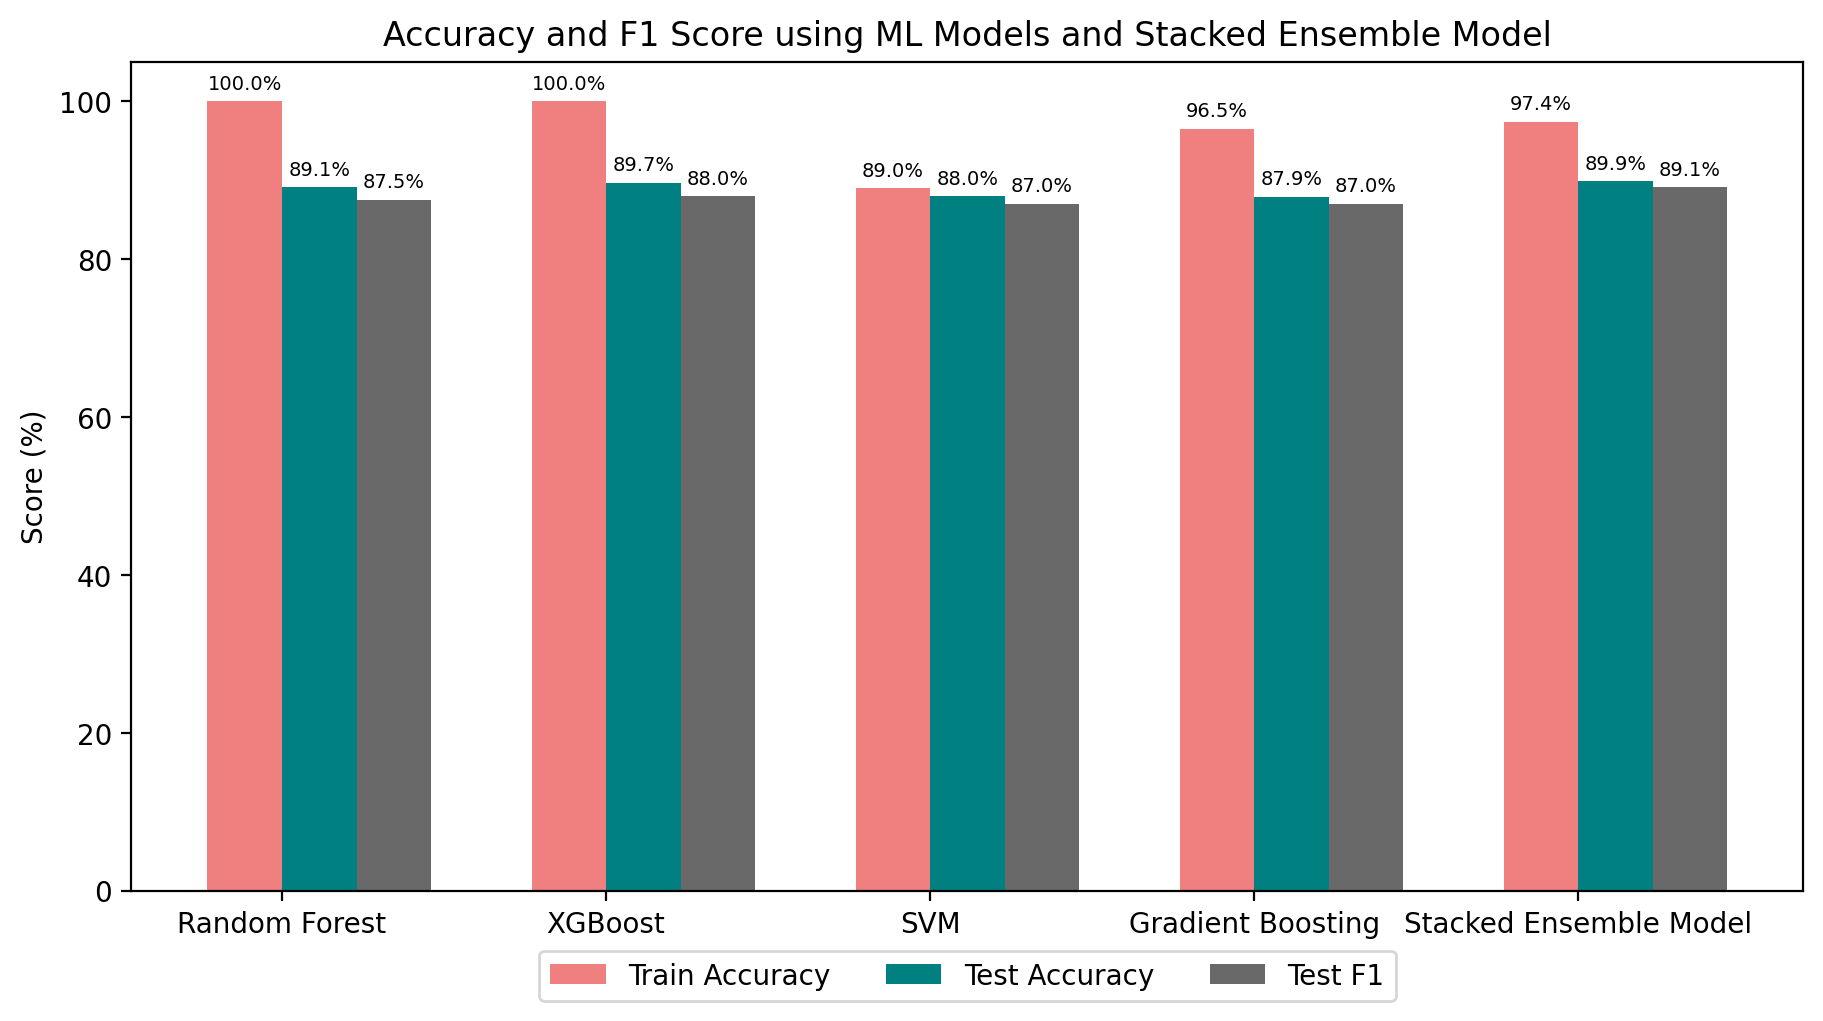

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define data
Classifiers = ('Random Forest', 'XGBoost', 'SVM', 'Gradient Boosting', 'Stacked Ensemble Model')
Scores = {
    'Train Accuracy': [1, 1, 0.89, 0.965, 0.974], 
    'Test Accuracy': [0.891, 0.897, 0.88, 0.879, 0.899],
    'Test F1': [0.875, 0.88, 0.87, 0.87, 0.891]
}


Scores_percentage = {key: [val * 100 for val in value] for key, value in Scores.items()}
df_res = pd.DataFrame(Scores_percentage)

# Define x-axis positions
x = np.arange(len(Classifiers))
width = 0.23
multiplier = 0

# Define colors
colors = ['#F08080', '#008080', '#696969']
# Create figure and axis
fig, ax = plt.subplots(layout='constrained', figsize=(9, 5))

# Iterate through Scores dictionary to plot bars with different colors
for (attribute, measurement), color in zip(Scores_percentage.items(), colors):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=color)
    ax.bar_label(rects, fmt="%.1f%%", padding=3, fontsize=7)
    multiplier += 1

# Set labels and titles
ax.set_ylabel('Score (%)')
ax.set_title('Accuracy and F1 Score using ML Models and Stacked Ensemble Model')
ax.set_xticks(x + width / 2, Classifiers)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3)
ax.set_ylim(0, 105)

# Show plot
plt.show()


# Heterogeneous stack ensemble model, with final estimator/meta learner Random forest classifier  

/bsuhome/maishamaliha/miniforge3/envs/climate/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/bsuhome/maishamaliha/miniforge3/envs/climate/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



 Model Evaluation (Stacking Ensemble):
 Training Accuracy: 0.9736
 Testing Accuracy: 0.8995
 Weighted F1 Score: 0.8909


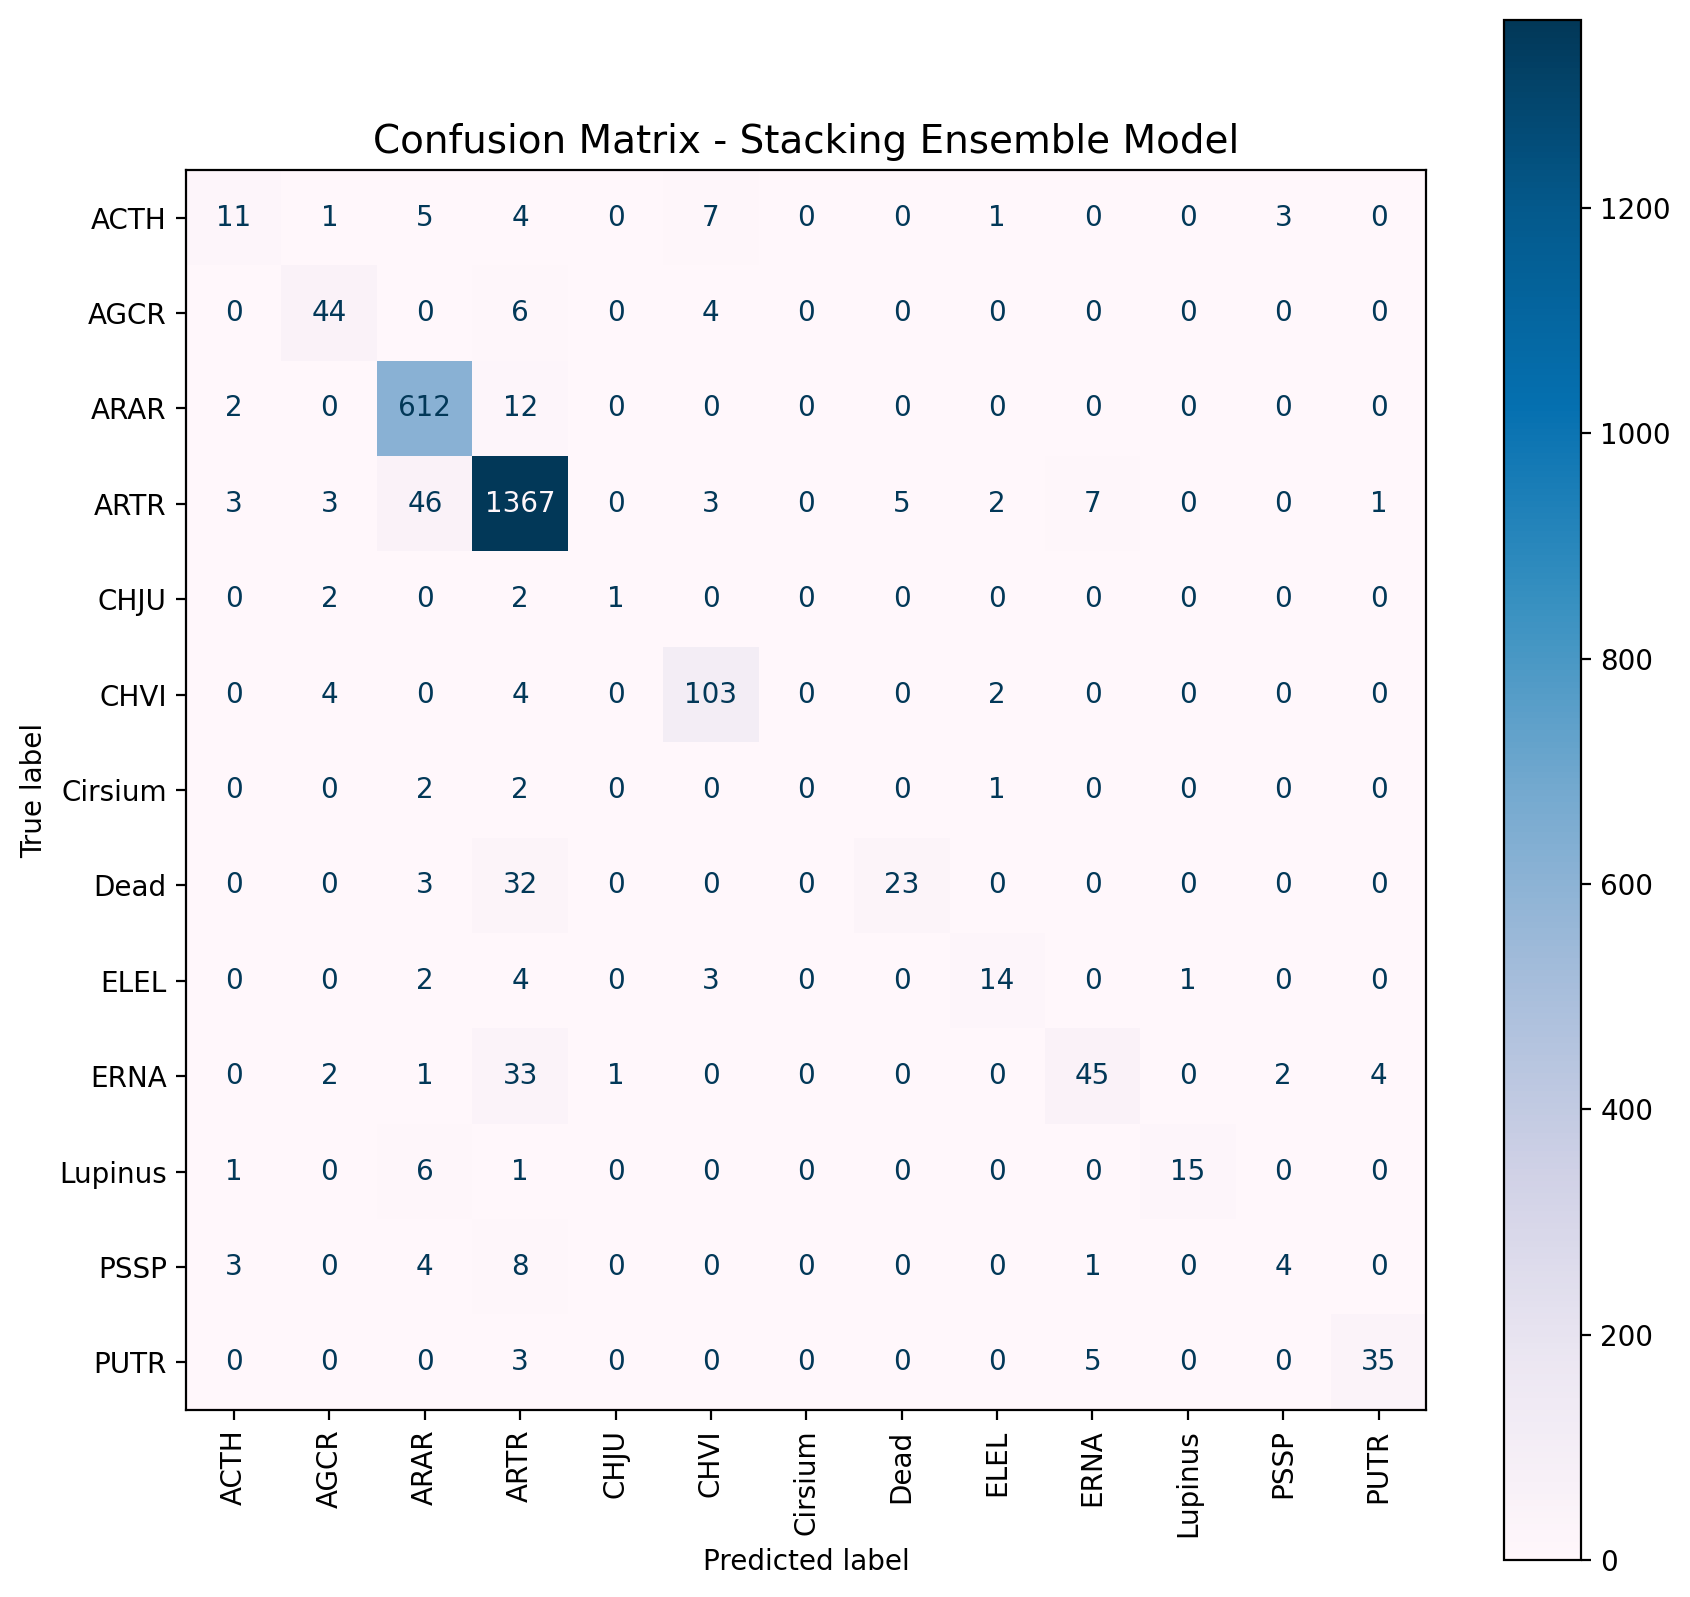

In [11]:

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier

#  individual models with pipeline
rfc_pipe = Pipeline([
    ('preprocessor', preprocessor1),
    ('classifier', RandomForestClassifier())
])

svc_pipe = Pipeline([
    ('preprocessor', preprocessor1),
    ('classifier', SVC(probability=True))
])

gbc_pipe = Pipeline([
    ('preprocessor', preprocessor1),
    ('classifier', GradientBoostingClassifier())
])

xgb_pipe = Pipeline([
    ('preprocessor', preprocessor1),
    ('classifier', XGBClassifier())
])

#  base models for stacking
base_estimators = [
    ('Random Forest', rfc_pipe.named_steps['classifier']),
    ('SVM', svc_pipe.named_steps['classifier']),
    ('GBC', gbc_pipe.named_steps['classifier']),
    ('XGB', xgb_pipe.named_steps['classifier'])
]

# stacking ensemble model
stacking_model = Pipeline([
    ('preprocessor', preprocessor1),
    ('classifier', StackingClassifier(
        estimators=base_estimators, 
        final_estimator=RandomForestClassifier(),  # Meta Learner
        passthrough=True, 
        n_jobs=-1  
    ))
])

stacking_model.fit(X_train, y_train)

# predictions
y_pred_train = stacking_model.predict(X_train)
y_pred_test = stacking_model.predict(X_test)

# accuracy & F1-Score 
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_st = f1_score(y_test, y_pred_test, average='weighted')

print("\n Model Evaluation (Stacking Ensemble):")
print(f" Training Accuracy: {accuracy_train:.4f}")
print(f" Testing Accuracy: {accuracy_test:.4f}")
print(f" Weighted F1 Score: {f1_st:.4f}")

cm = confusion_matrix(y_test, y_pred_test, labels=stacking_model.named_steps['classifier'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stacking_model.named_steps['classifier'].classes_)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='PuBu')
plt.title('Confusion Matrix - Stacking Ensemble Model', fontsize=14)
plt.xticks(rotation=90)
plt.show()

In [13]:
import os
import joblib  

# directory and filename to save the model
model_dir = "/bsuhome/maishamaliha/scratch/First_chapter_ML/results"
os.makedirs(model_dir, exist_ok=True)  # Ensure the directory exists
model_filename = os.path.join(model_dir, "stacked_ensemble_model.joblib")

joblib.dump(stacking_model, model_filename)
print(f"Stacked model saved to: {model_filename}")


Stacked model saved to: /bsuhome/maishamaliha/scratch/First_chapter_ML/results/stacked_ensemble_model.joblib
